In [521]:
import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
importlib.reload(function)
from PIL import Image
from function import calc_dist,calc_theta,rotate_point,match_points,calc_edge_list,plot_stars


In [522]:
def csv_to_human_test_data(filename):
    df=pd.read_csv(filename)

    names=df['name'].values
    x=df['x'].values
    y=df['y'].values
    p=df['p'].values
    position=np.column_stack((x,y))
    idx_Lsho=np.where(names=='L_shoulder')[0][0]
    idx_Rsho=np.where(names=='R_shoulder')[0][0]
    neck_position=(position[idx_Lsho]+position[idx_Rsho])/2

    idx_Lwai=np.where(names=='L_waist')[0][0]
    idx_Rwai=np.where(names=='R_waist')[0][0]
    stomach_position=(position[idx_Lwai]+position[idx_Rwai])/2

    new_name=np.array(['Neck','Stomach'])
    new_position=np.array([neck_position,stomach_position])
    names=np.concatenate((new_name,names))
    position=np.vstack((new_position,position))
    
    return names,position

In [523]:
class Local:
    def __init__(self,direction=None):
        self.direction=direction
        self.min_dist=None
        self.min_stars=None
        self.min_a_points=None
        self.edge_list=None
        self.near_dot=None
        self.star_data=None
        self.dotsize_x=None
        self.dotsize_y=None
        self.reshaped_position=None
        self.min_norm=None
        self.min_theta=None

    def __str__(self):
        return self.direction


In [524]:

class Search_min:
    def __init__(self,local_list=[]):
        self.local_list=local_list

    def add_local(self,local):
        self.local_list.append(local)
        
    def print_result(self,point_edge_list):
        min_dist=float('inf')
        min_local=None
        for local in self.local_list:
            if local.min_dist<min_dist:
                min_dist=local.min_dist
                min_local=local
        if min_local.direction=='north':
            print('north')
            plot_stars([north],point_edge_list)
        elif min_local.direction=='south':
            print('south')
            plot_stars([south],point_edge_list)
        elif min_local.direction=='equator' or min_local.direction=='ex_equator':
            print(min_local)
            plot_stars([equator,ex_equator],point_edge_list)
        else:
            print(error)
        



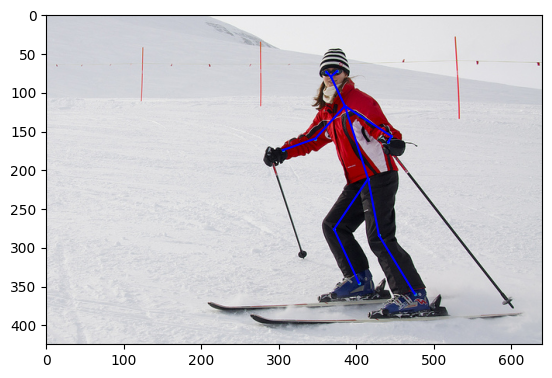

In [534]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('../point_data/human_test/for presentation/000000000785.jpg')

point_data=np.load('../point_data/human_test/for presentation/sample_data.npy')
point_edge_list=np.load('../point_data/human_test/for presentation/sample_edge.npy')
x=point_data[:,1]
y=point_data[:,2]
x=x.astype(float)
y=y.astype(float)
raw_points=np.column_stack((x,y))
plt.imshow(img)
plt.scatter(x,y,s=2)
for edge in point_edge_list:
    p1=raw_points[edge[0]]
    p2=raw_points[edge[1]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')

plt.show()

[[  0.   0.]
 [ 30.  94.]
 [-18. -38.]
 [-10. -45.]
 [-24. -44.]
 [ 60.  39.]
 [-38.  42.]
 [ 56.  47.]
 [-80.  57.]
 [ 44. 167.]
 [-14. 159.]
 [ 90. 242.]
 [ 18. 228.]]


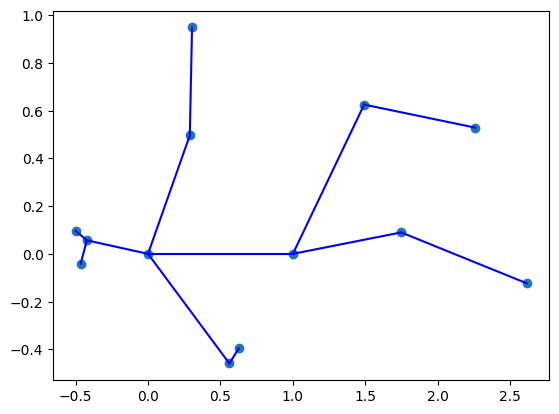

In [537]:
points_size=len(raw_points)
points=np.zeros((points_size,2))
for i in range(1,points_size):
    points[i]=raw_points[i]-raw_points[0]
points[0]=np.array([0,0])
points_norm=np.linalg.norm(points[1])
points_theta=calc_theta(points[1])
for i  in range(1,points_size):
    points[i]=rotate_point(points[i]/points_norm,(-1)*points_theta)

plt.scatter(points[:,0],points[:,1])
for edge in point_edge_list:
    p1=points[edge[0]]
    p2=points[edge[1]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')

In [528]:
north=Local('north')
south=Local('south')
equator=Local('equator')
ex_equator=Local('ex_equator')

all_locals=Search_min([north,south,equator,ex_equator])


In [529]:
#データの読み込み、クラスの初期化
for direction in [north,south,equator,ex_equator]:
    star_data_url=f'./data/{direction.direction}/star_data.npy'
    near_dot_url=f'./data/{direction.direction}/near_dot.npy'
    reshaped_position_url=f'./data/{direction.direction}/reshaped_position.npy'
    direction.star_data=np.load(star_data_url)
    direction.near_dot=np.load(near_dot_url)
    direction.reshaped_position=np.load(reshaped_position_url)
    if direction==north or direction==south:
        direction.dotsize_x=200
        direction.dotsize_y=200
    elif direction==equator:
        direction.dotsize_x=400
        direction.dotsize_y=100
    else:
        direction.dotsize_x=200
        direction.dotsize_y=100
        


In [530]:
#edge_listの計算
for direction in [north,south,equator,ex_equator]:
    x,y=direction.star_data[:,0],direction.star_data[:,1]
    direction.edge_list=calc_edge_list(x,y,0,0.15)



In [531]:
for direction in [north,south,equator,ex_equator]: 
    print(direction)
    star_data=direction.star_data  
    reshaped_position=direction.reshaped_position
    x,y,lum,HIPnum=star_data[:,0],star_data[:,1],star_data[:,2],star_data[:,3]
    a_x=reshaped_position[:,0]
    a_y=reshaped_position[:,1]
    size=7*np.exp(-1*(lum+2)*np.log(2))
    penalty_of_size=8*np.exp(-5*size*np.log(2)-1)
    direction.min_dist=float('inf')
    #print(len(a_x))
    for edge in direction.edge_list:
        node1,node2=edge
        star_1=reshaped_position[node1]
        star_2=reshaped_position[node2]
        norm=np.linalg.norm(star_2-star_1)
        theta=calc_theta(star_2-star_1)
        a_points=match_points(points,norm,theta,star_1)
        near_stars=[-1 for _ in range(points_size)]
        dist=0
        for i in range(points_size):
            a_point=a_points[i]
            a_point_x=int(round(a_point[0],0))
            a_point_y=int(round(a_point[1],0))
            #ここの処理は変えたほうがいいかも
            if a_point_x<0 or a_point_x>=direction.dotsize_x or a_point_y<0 or a_point_y>=direction.dotsize_y:
                break
            indice3=direction.near_dot[a_point_y][a_point_x]
            nearest_star=np.array([a_x[indice3],a_y[indice3]]).reshape(-1)
            dist+=np.sum((a_point-nearest_star)**2)/(norm**(2))
            near_stars[i]=indice3
            if dist>direction.min_dist:
                break
            if i==points_size-1:
                shape_penalty_rate=0
                for j in range(points_size):
                    shape_penalty_rate+=penalty_of_size[near_stars[j]]
                    for k in range(j+1,points_size):
                        if near_stars[j]==near_stars[k]:
                            if (j,k) in direction.edge_list:
                                shape_penalty_rate+=0.5
                            else:
                                shape_penalty_rate+=1
                shape_penalty_rate+=norm/30
                dist=dist*(1+shape_penalty_rate)
                if dist>direction.min_dist:
                    break
                direction.min_dist=dist 
                direction.min_stars=near_stars
                direction.min_a_points=a_points
                direction.min_theta=theta
                direction.min_norm=norm
            if dist>direction.min_dist:
                break
    print(direction.min_dist)





north
0.2577485522755203
south
0.2987395236961794
equator
0.19520182011805617
ex_equator
0.3163407154470373


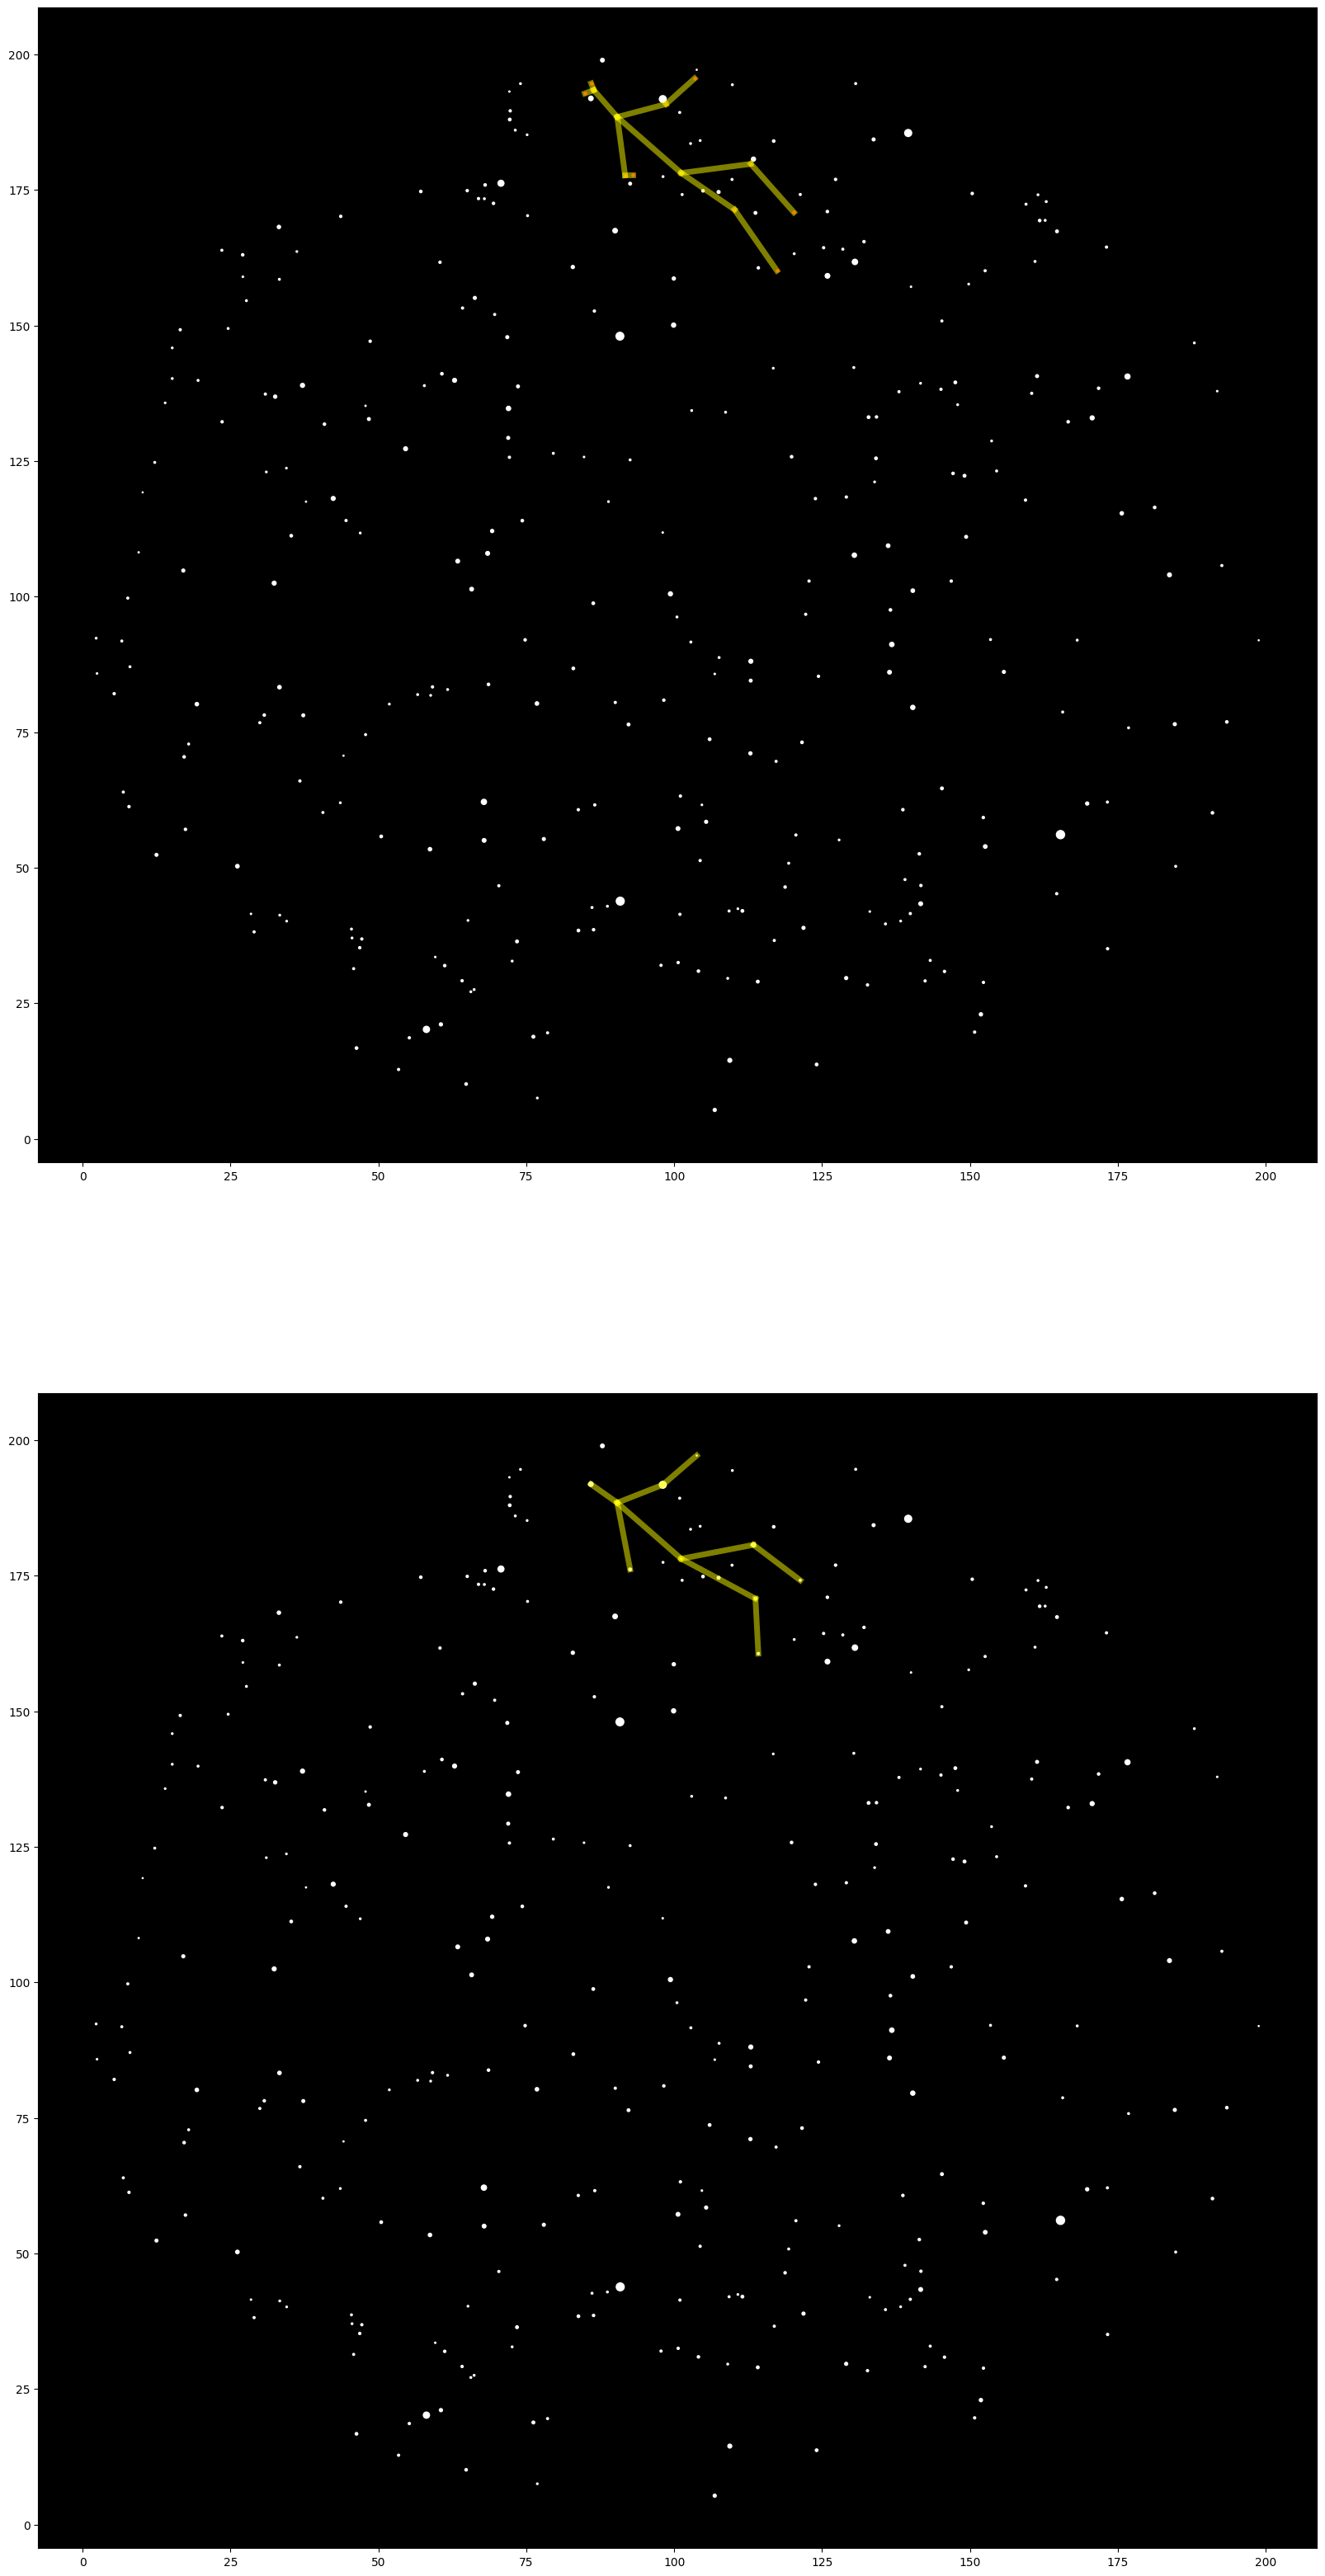

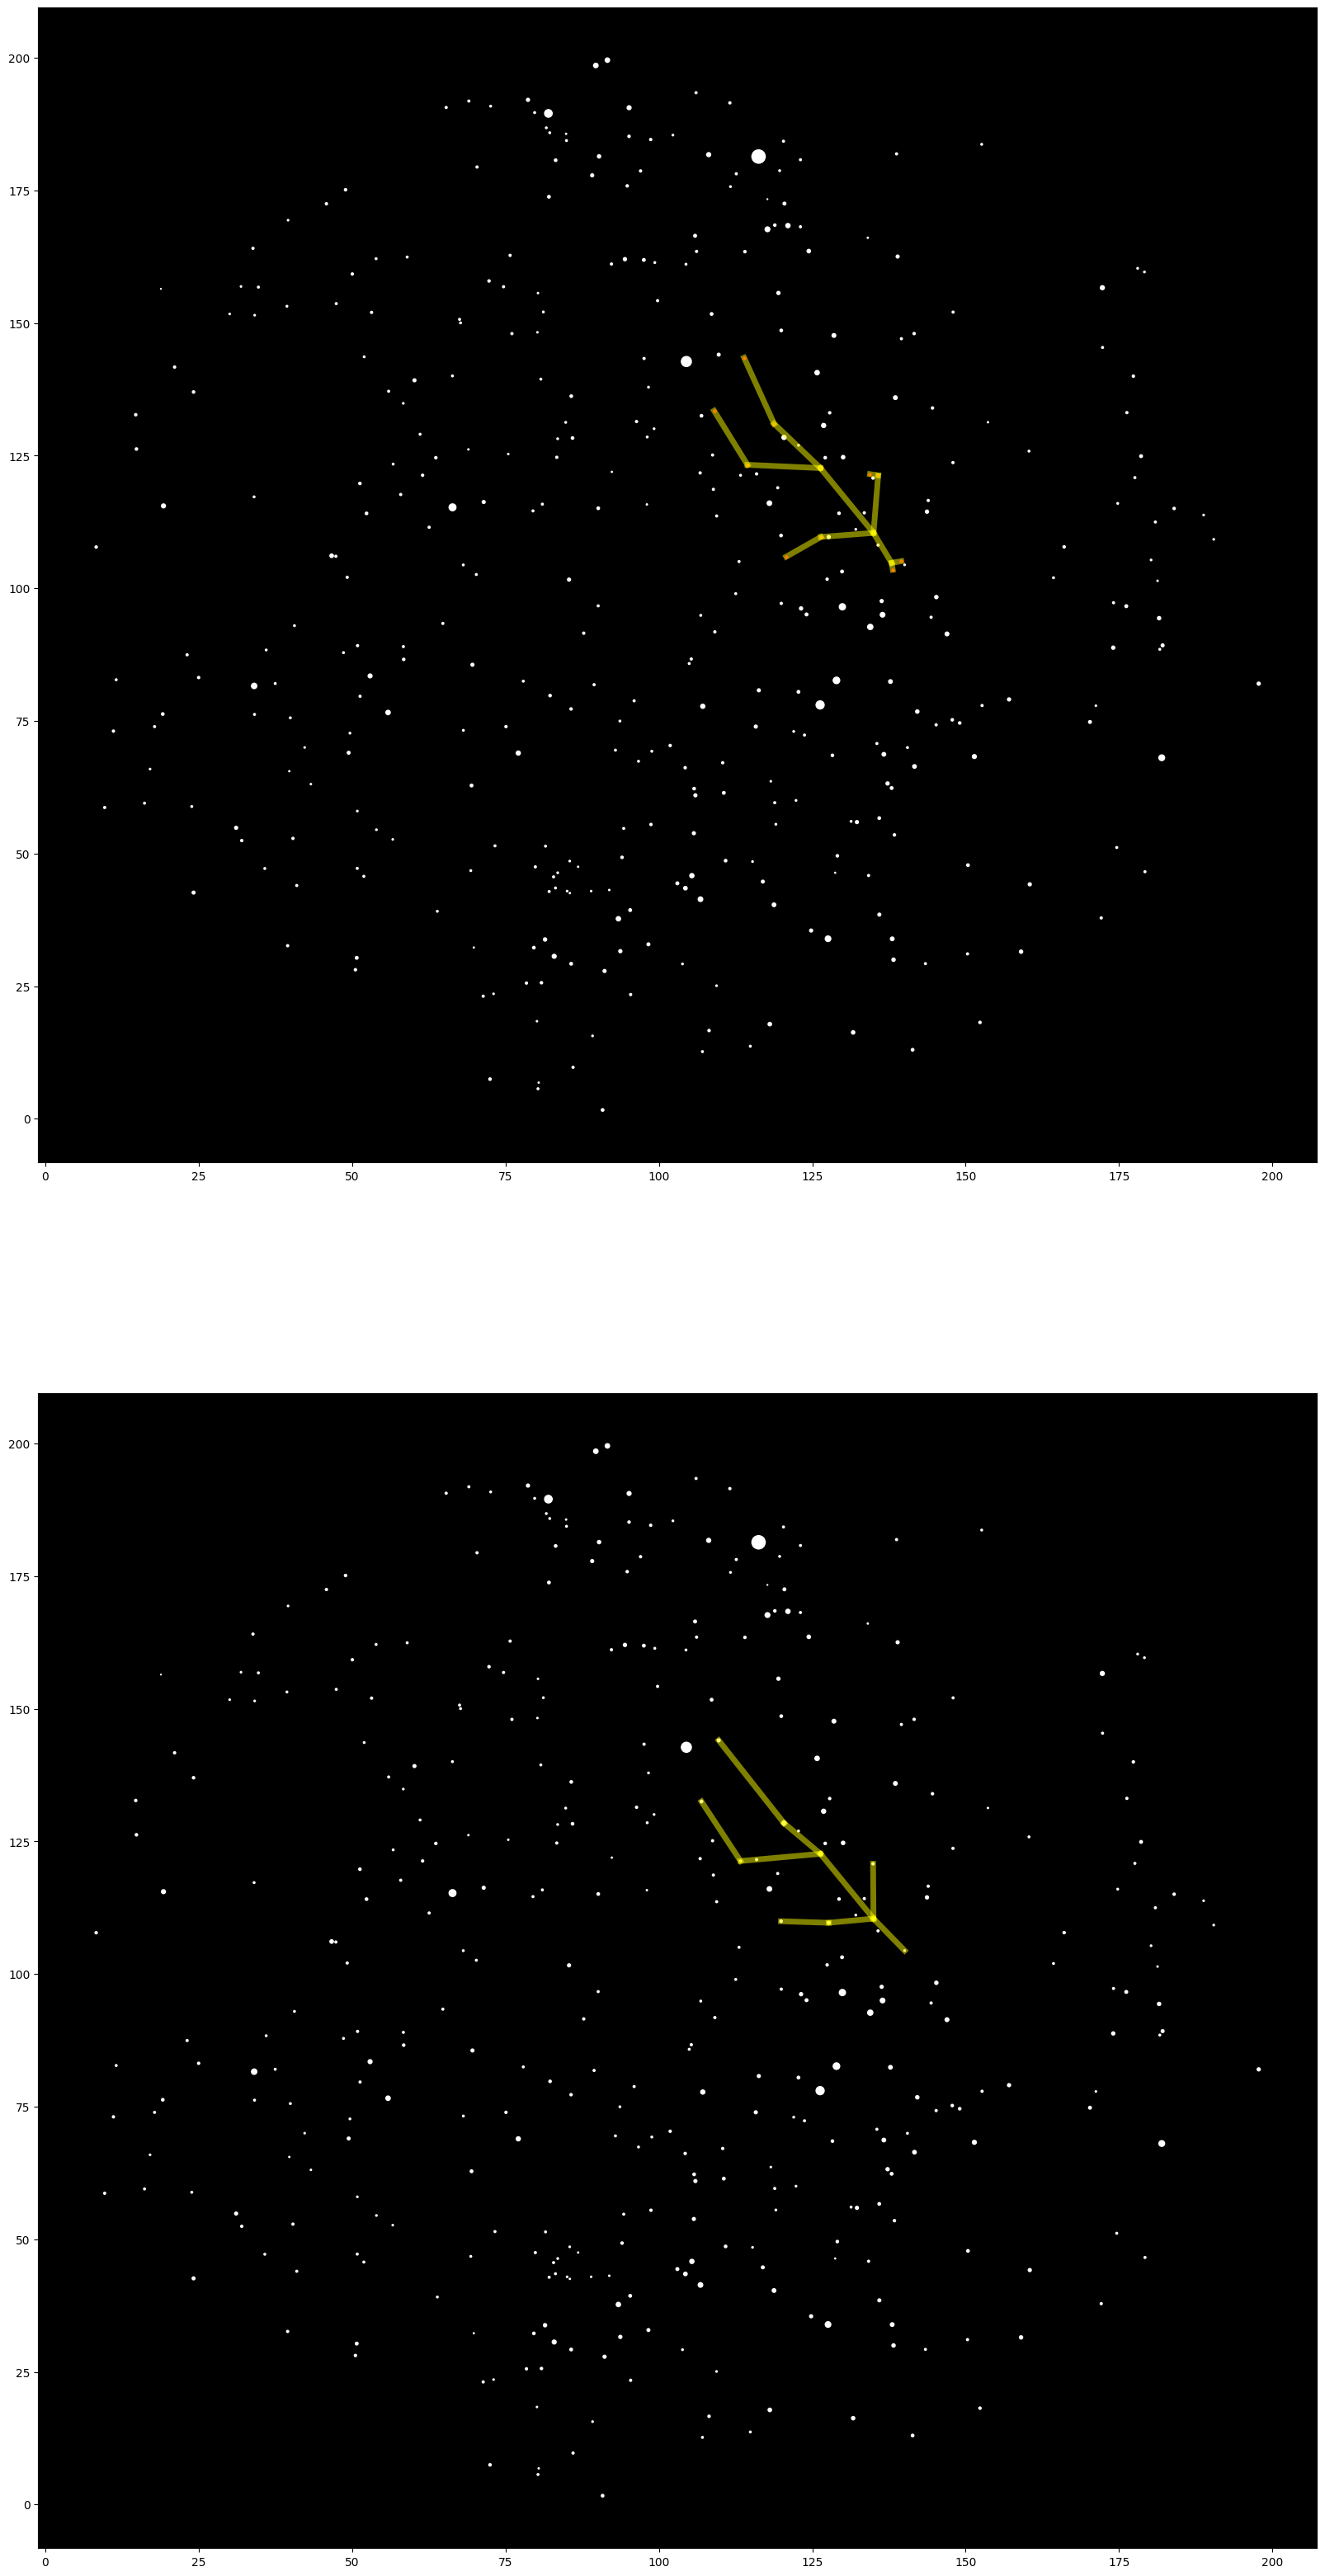

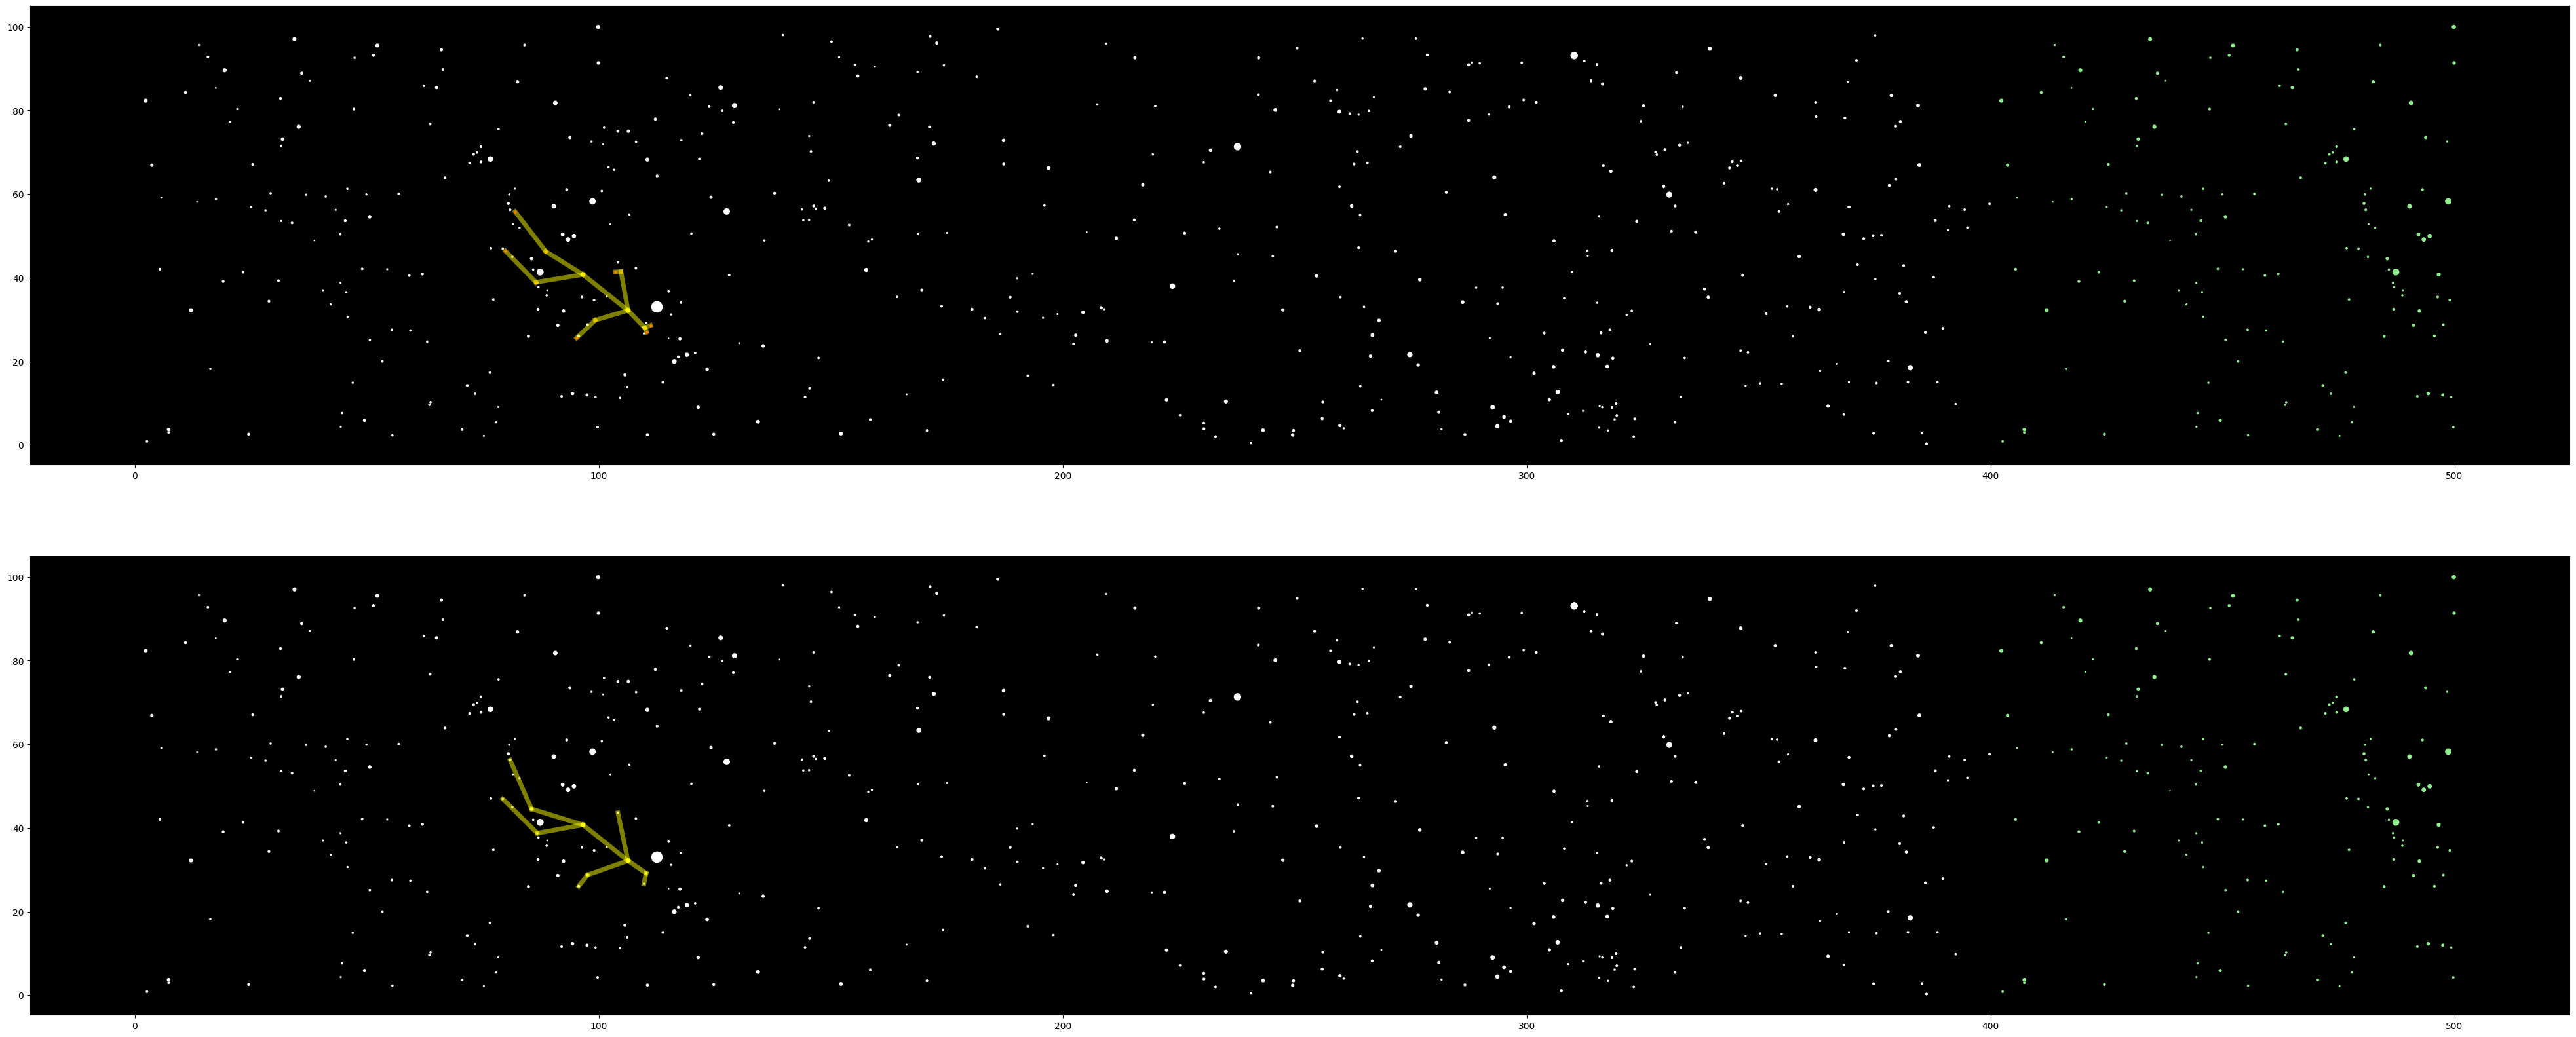

In [532]:
plot_stars([north],point_edge_list)
plot_stars([south],point_edge_list)
plot_stars([equator,ex_equator],point_edge_list)

equator


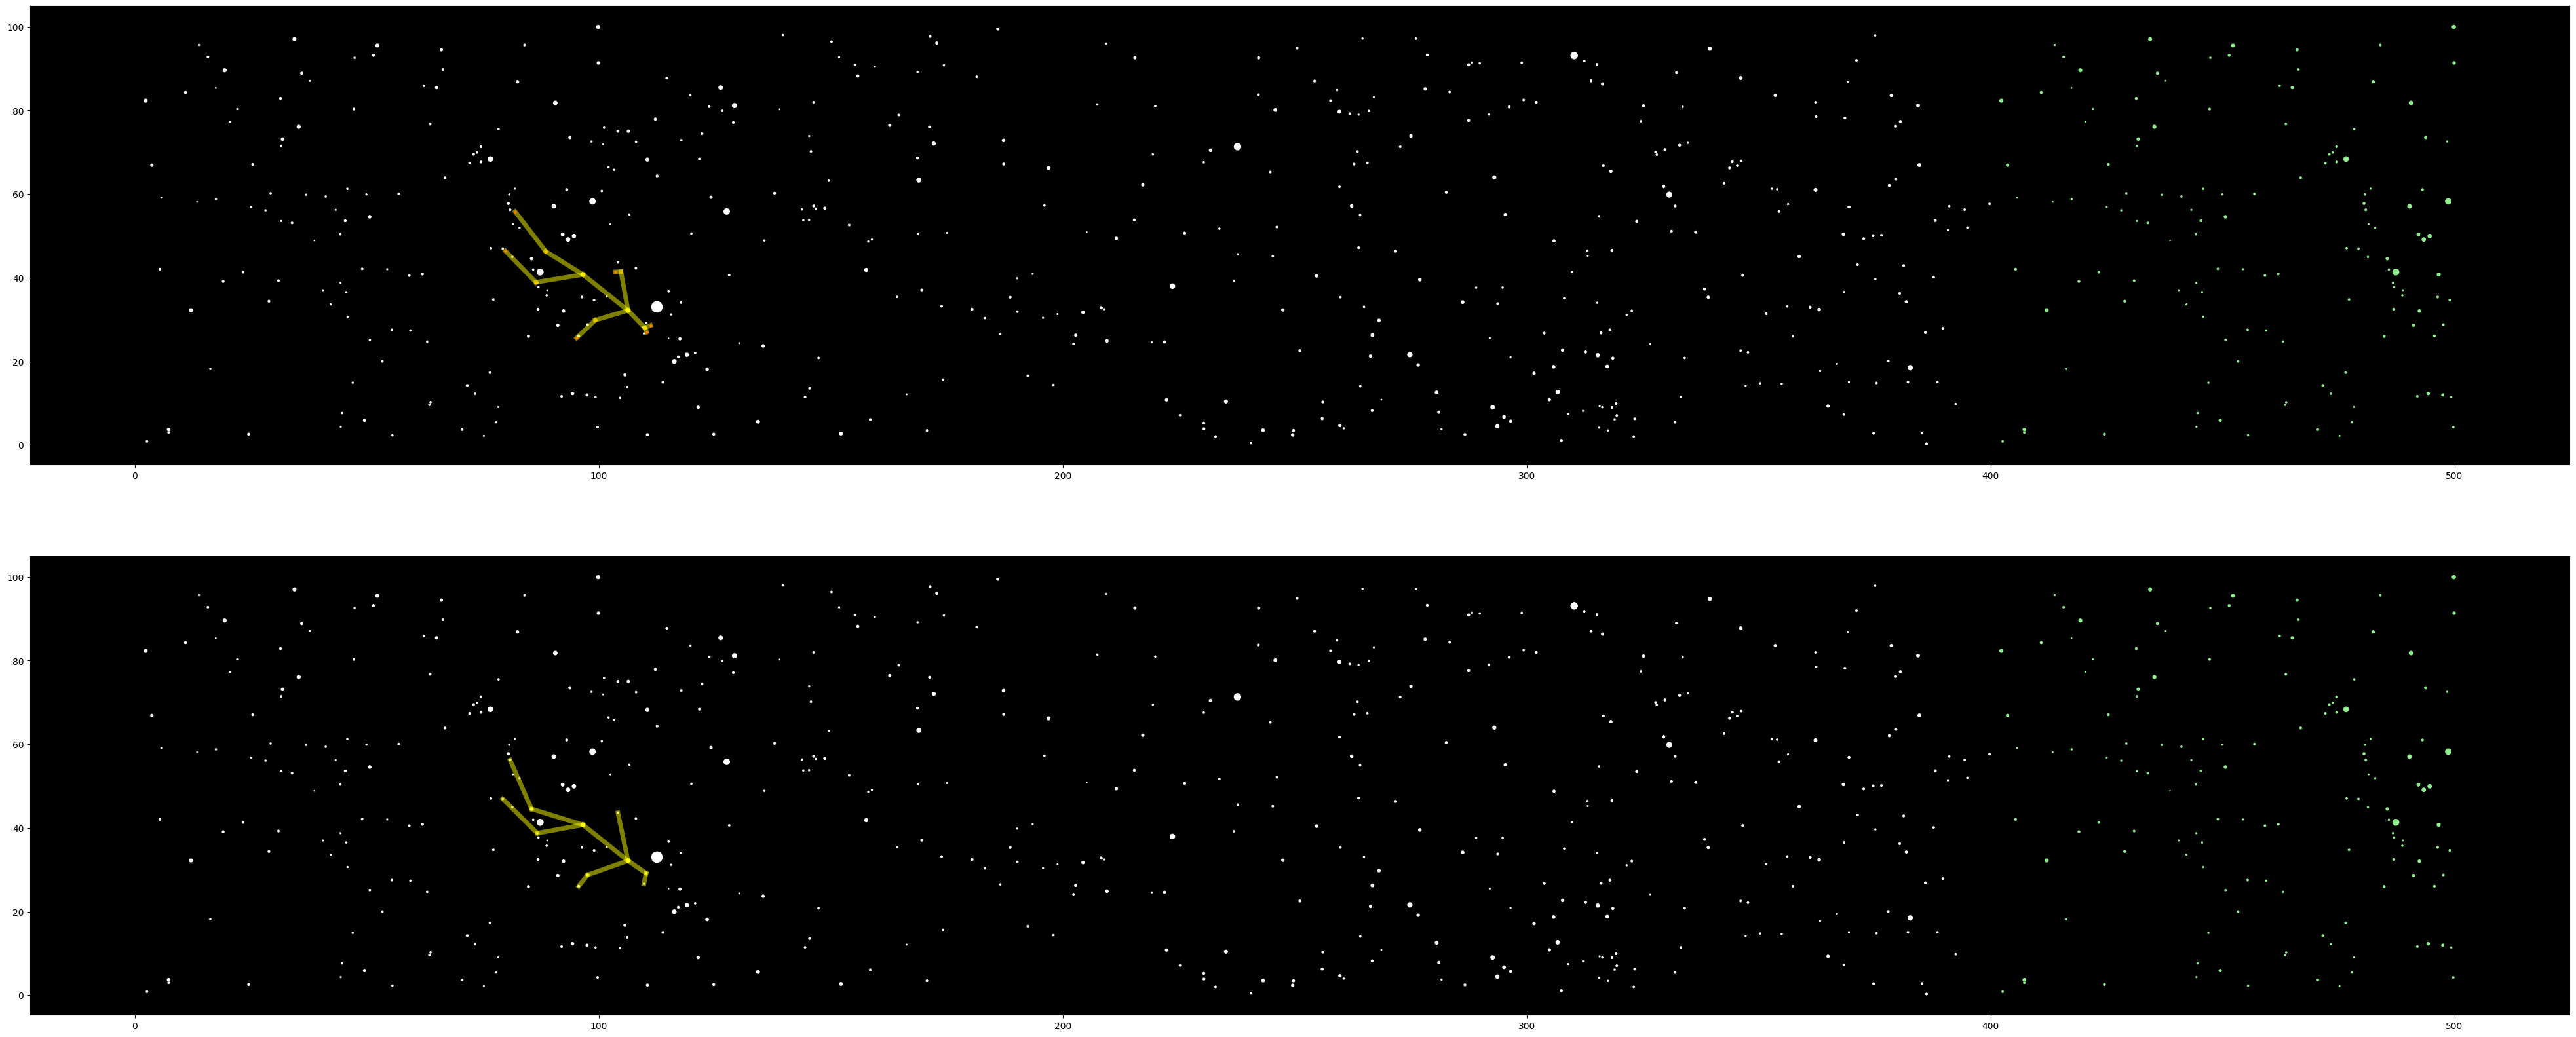

In [503]:
all_locals.print_result(point_edge_list)

In [510]:
point_data=np.load('../point_data/human_test/for presentation/sample_data.npy')
point_edge_list=np.load('../point_data/human_test/for presentation/sample_edge.npy')
x=point_data[:,1]
y=point_data[:,2]
x=x.astype(float)
y=y.astype(float)
points=np.column_stack((x,y))
direction=equator
image = Image.open('../point_data/human_test/for presentation/000000000785.jpg')
width, height = image.size
resize_rate=direction.min_norm/points_norm
rotate_theta=direction.min_theta-points_theta


In [511]:
def resize_and_rotate_image(image_path,resize_rate,point):
    image = Image.open(image_path)
    width, height = image.size
    center_x=point[0]
    center_y=point[1]
    resized_image = image.resize((int(width*resize_rate), int(height*resize_rate)))
    image_array = np.array(resized_image)
    return image_array

In [512]:
image_array=resize_and_rotate_image('../point_data/human_test/for presentation/000000000785.jpg',resize_rate ,points[0])


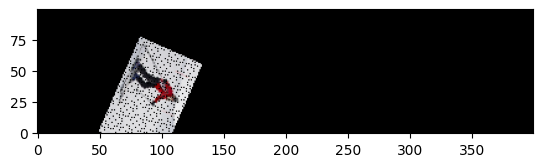

In [516]:

reshaped_image_array=np.zeros((direction.dotsize_y,direction.dotsize_x,3),dtype=int)
y_size=image_array.shape[0]
x_size=image_array.shape[1]

x_center=int(round(points[0][0]*resize_rate,0))
y_center=int(round(points[0][1]*resize_rate,0))
x_destination=int(round(direction.min_a_points[0][0],0))
y_destination=int(round(direction.min_a_points[0][1],0))
x_diff=int(x_destination-x_center)
y_diff=int(y_destination-y_center)

for i in range(y_size):
    for j in range(x_size):
        re_i=i-y_center
        re_j=j-x_center
        p=np.array([re_j,re_i])
        rotated_p=rotate_point(p,rotate_theta)
        ro_i=int(round(rotated_p[1],0))
        ro_j=int(round(rotated_p[0],0))
        if ro_i+y_destination<0 or ro_j+x_destination<0:
            continue
        try:
            reshaped_image_array[ro_i+y_destination][ro_j+x_destination]=image_array[i][j]
        except IndexError:
            pass

'''
for i in range(y_size):
    for j in range(x_size):
        re_i=i-y_center
        re_j=j-x_center
        try:
            reshaped_image_array[i+y_diff][j+x_diff]=image_array[i][j]
        except IndexError:
            pass


reshaped_image_array = reshaped_image_array.astype(np.uint8)

fig, ax = plt.subplots()
ax.imshow(reshaped_image_array)
ax.invert_yaxis()
plt.show()



reshaped_image = Image.fromarray(reshaped_image_array)

reshaped_image=reshaped_image.rotate(-rotate_theta*180/np.pi,center=(x_destination,y_destination))

reshaped_image_array=np.array(reshaped_image) 
'''

fig, ax = plt.subplots()
ax.imshow(reshaped_image_array)
ax.invert_yaxis()
plt.show()



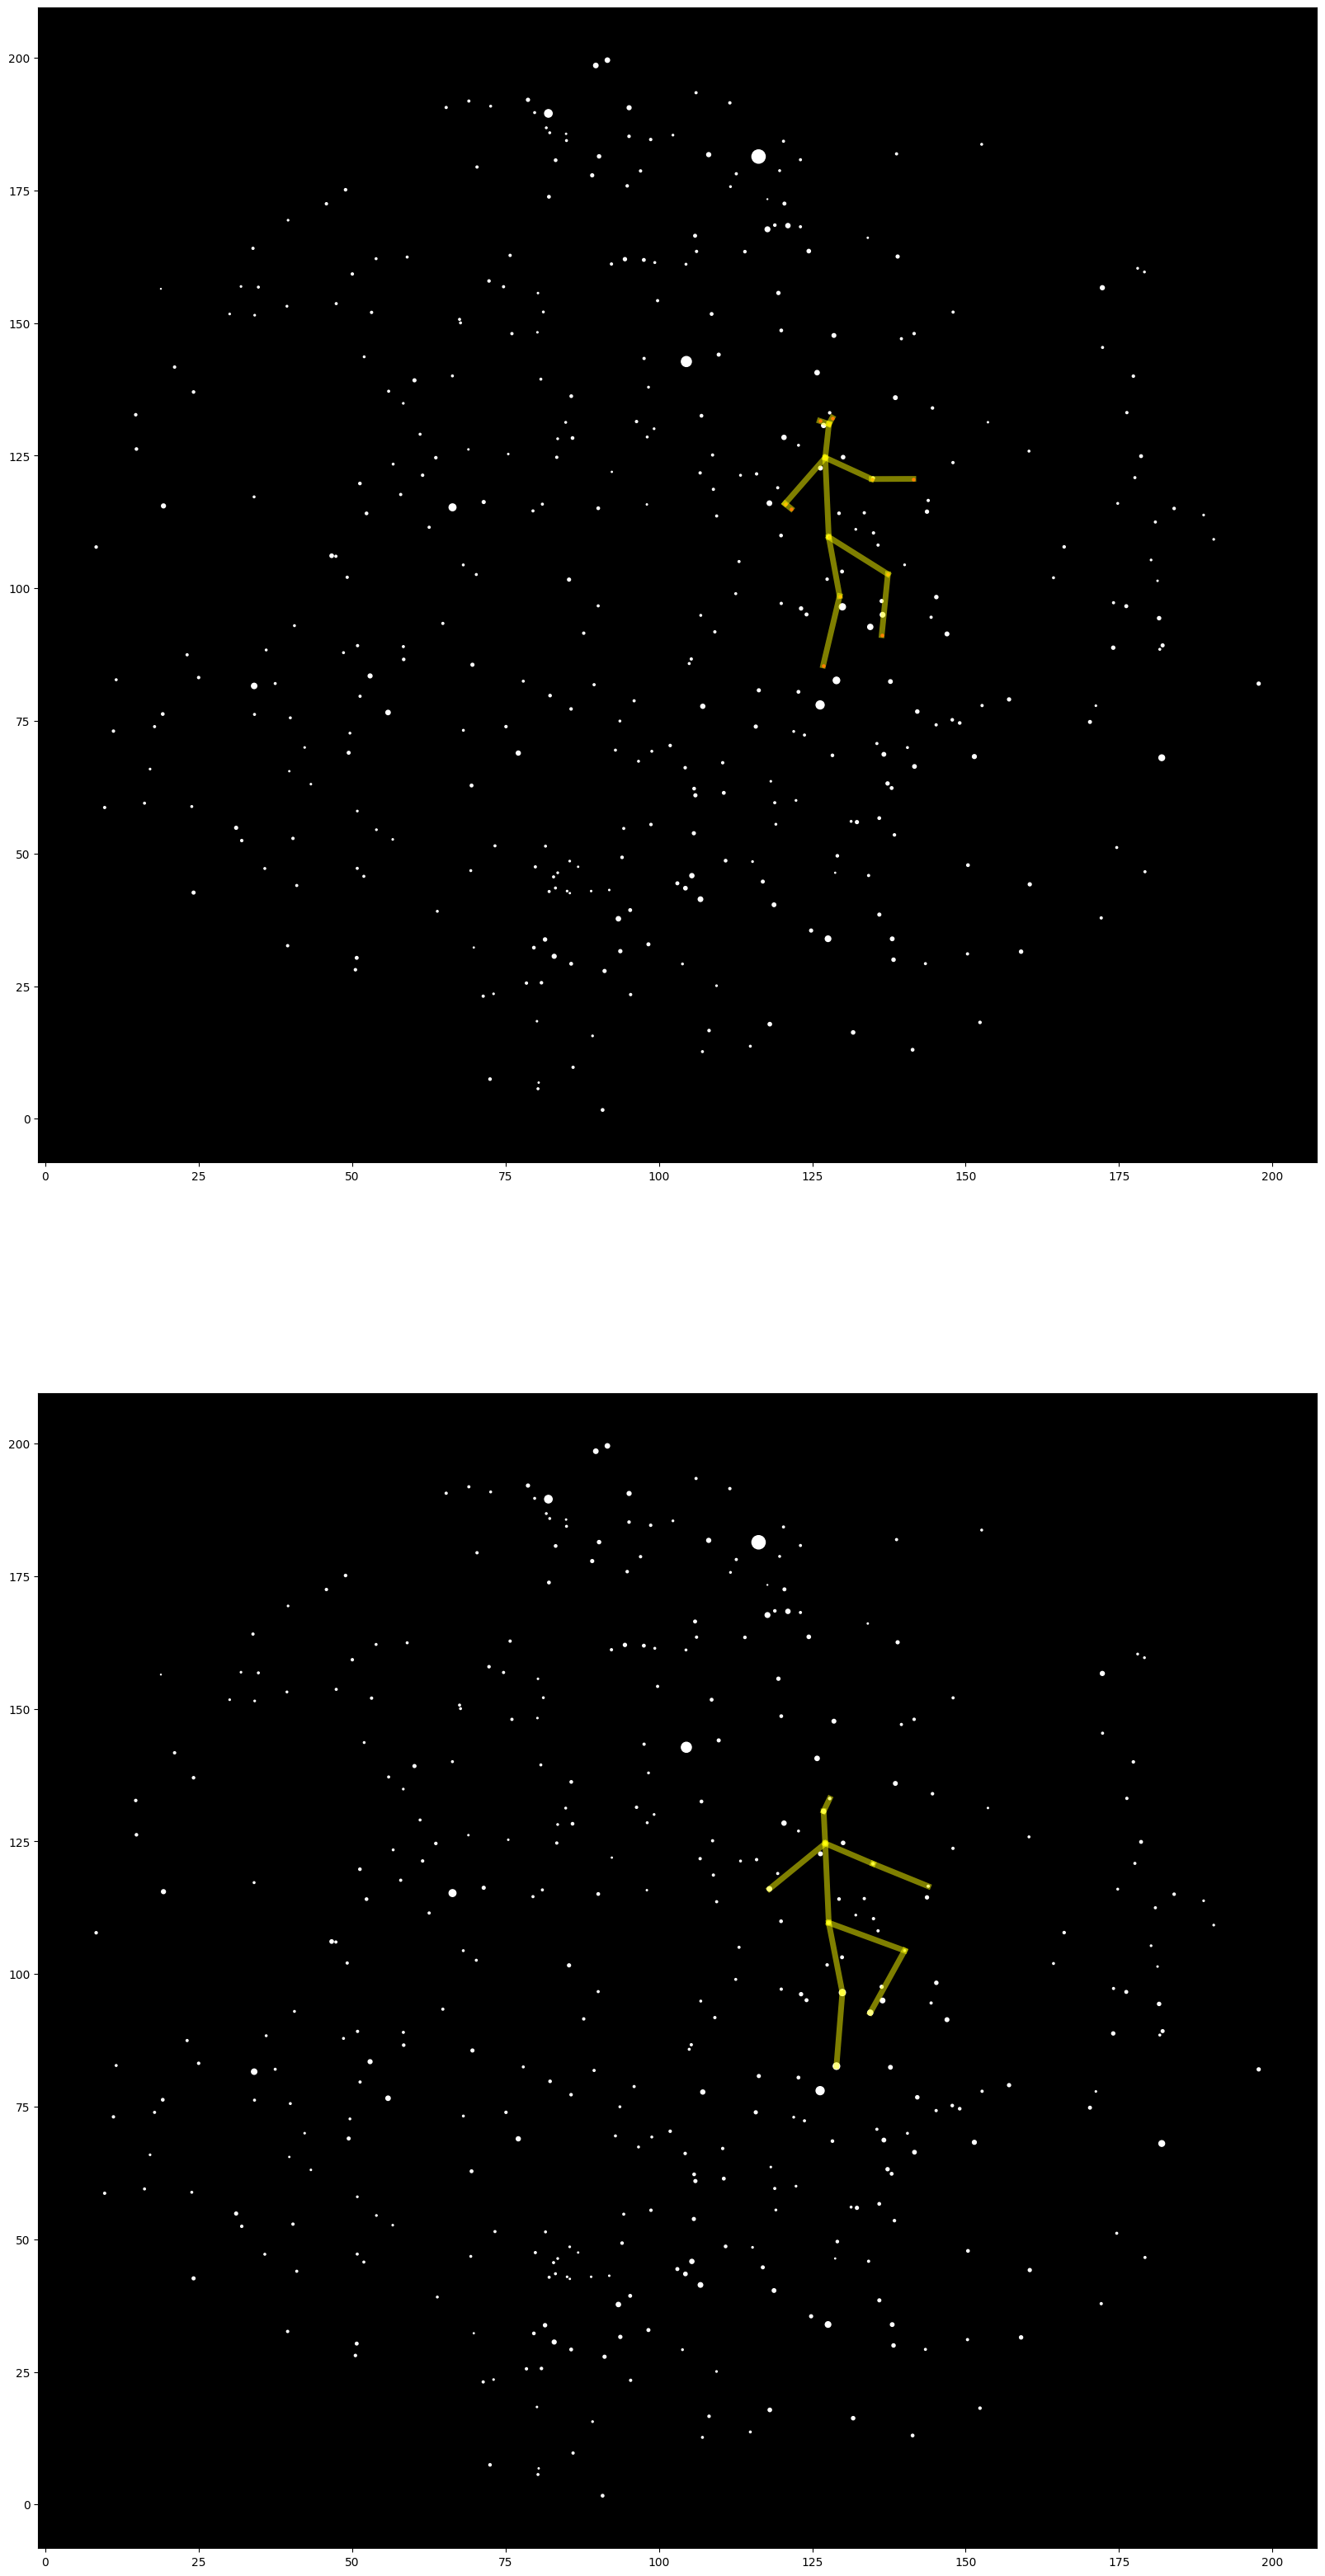

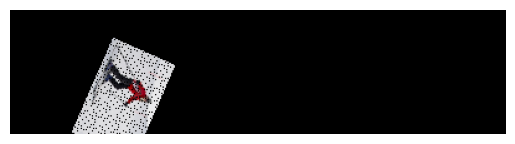

In [517]:
plot_stars([south],point_edge_list)




fig, ax = plt.subplots()
ax.imshow(reshaped_image_array)
ax.invert_yaxis()
ax.axis('off')
plt.show()

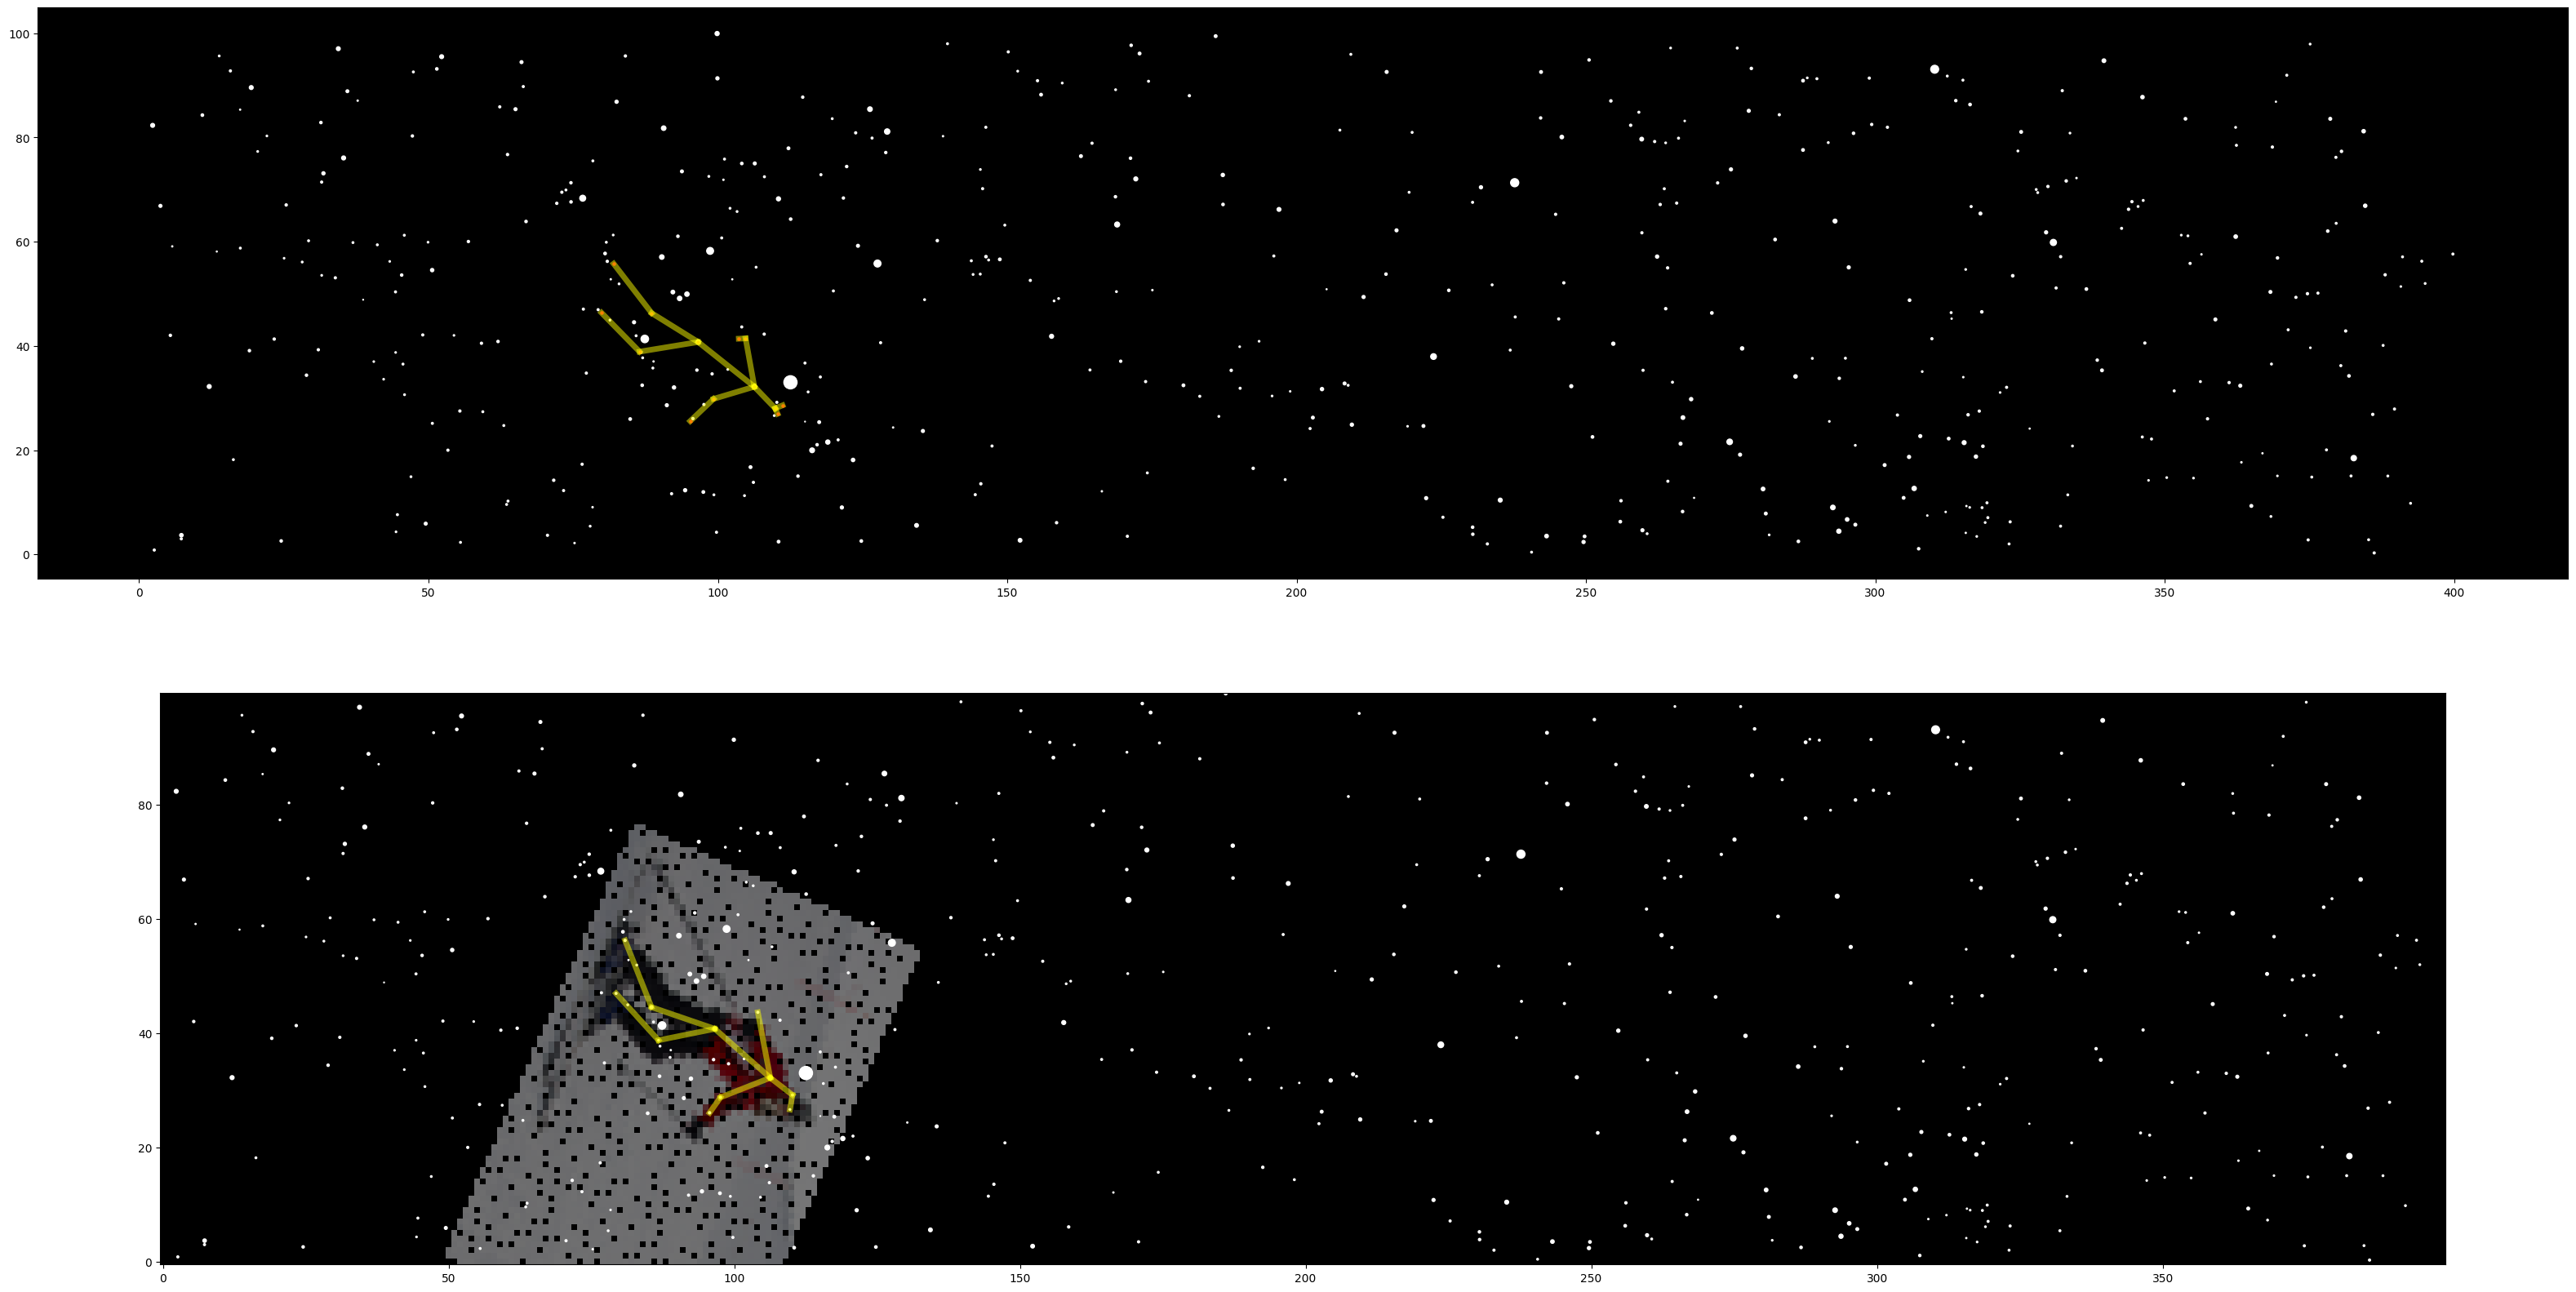

In [520]:
a_points=direction.min_a_points
a_x=direction.reshaped_position[:,0]
a_y=direction.reshaped_position[:,1]
lum=direction.star_data[:,2]
size=200*np.exp(-1*(lum+2)*np.log(2))
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(direction.dotsize_x/10,direction.dotsize_y*2/10))
for ax in axes:
    ax.set_facecolor('black')
    ax.scatter(a_x,a_y,s=size,color='white')
axes[0].scatter(direction.min_a_points[:,0],direction.min_a_points[:,1],color='red',s=5)
for edge in point_edge_list:
    p1=direction.min_a_points[edge[0]]
    p2=direction.min_a_points[edge[1]]
    axes[0].plot((p1[0],p2[0]),(p1[1],p2[1]),color='yellow',alpha=0.5,lw=5)
for edge in point_edge_list:
    p1=direction.reshaped_position[direction.min_stars[edge[0]]]
    p2=direction.reshaped_position[direction.min_stars[edge[1]]]
    axes[1].plot((p1[0],p2[0]),(p1[1],p2[1]),color='yellow',alpha=0.5,lw=5)

axes[1].imshow(reshaped_image_array,alpha=0.5)
axes[1].invert_yaxis()
plt.show()
